# Example 10: Composition scaling

In this notebook, we will calculate the free energy of a binary ZrCu system as a function of the composition. The structure that will be considered is ZrCu with a B2 structure. The potential that will be used is-

[M.I. Mendelev , M.J. Kramer , R.T. Ott , D.J. Sordelet , D. Yagodin & P. Popel (2009) Development of suitable interatomic potentials for simulation of liquid and amorphous Cu–Zr alloys, Philosophical Magazine, 89:11, 967-987](http://dx.doi.org/10.1080/14786430902832773)

In the first part of the example, a simple free energy difference that happens when a substitutional atom is introduced is calculated in two ways. In the second part, we directly calculate the free energy as the composition varies in the given system.

## Free energy change with substitutional atom

In the file [`ZrCu.data`](ZrCu.data), CuZr in B2 structure is provided. The file [`ZrCu_substitution.data`](ZrCu_substitution.data) contains the same structure, but a single atom of Zr is replaced with Cu. If the free energy of both structures are calculated, the difference between the two provides the free energy change when a substitutional Cu atom is introduced.

The input files for the direct calculations are [`input-direct-1.yaml`](input-direct-1.yaml) and [`input-direct-2.yaml`](input-direct-2.yaml). The calculations can be run by `calphy -i inputfilename`. Once the calculations are over, we can read in the results and analyse them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from calphy.input import read_report
from uncertainties import ufloat

We import the `read_report` method as shown above. This allows for easy reading of calphy output files. The data from the pure structure is read into `fe_ref_direct` and the data with the substitutional atom is in `fe_sub_direct`. We also import the [`uncertainties`](https://pythonhosted.org/uncertainties/) package, which will allow us to work with error bars.

In [2]:
fe_ref_direct = read_report("fe-zrcu.data-solid-800-0")
fe_sub_direct = read_report("fe-zrcu_substitution.data-solid-800-0")

Now calculate the difference in free energy between the two structures. We create `ufloat` objects to do operations including error bars.

In [3]:
fe_ref = ufloat(fe_ref_direct["results"]["free_energy"], fe_ref_direct["results"]["error"])
fe_sub = ufloat(fe_sub_direct["results"]["free_energy"], fe_sub_direct["results"]["error"])

Now the difference

In [4]:
fe_sub - fe_ref

0.003912274087720213+/-9.587447227178194e-05

Another way to do the same calculation is through the `composition_scaling` mode in calphy. The input is given in the file [`input-substitution.yaml`](input-substitution.yaml). The mode is `composition_scaling`. Further more, there is a new block in the input file:


```
composition_scaling:
  output_chemical_composition:
     - Cu: 513
     - Zr: 511
```

which provides the details for composition change. The `input_chemical_composition` shows equal number of Cu and Zr atoms as expected in the B2 structure. The `output_chemical_composition` has 513 Cu and 511 Zr atoms, which means that one Cu atom is substituted for Zr over the calculation.

As usual, the calculation can be run by:

```
calphy -i input.yaml
```

Once the calculation is over, we can read in the data.

In [5]:
fe_sub_comp = read_report("sub-composition_scaling-zrcu.data-solid-800-0")

In [6]:
fe_sub_comp = ufloat(fe_sub_comp["results"]["free_energy"], fe_sub_comp["results"]["error"])
fe_sub_comp

0.003867563953975235+/-9.690698549823455e-06

Both approaches we tried agree very well with each other. The second method needs only one single calculation instead of two different ones, and exhibits lower error overall. We can extend this approach to find the free energy as a function of the composition over a given range.

## Free energy variation with composition

The `composition_scaling` block in the input file looks slightly different here:

```
composition_scaling:
  input_chemical_composition:
     - Cu: 512
     - Zr: 512
  output_chemical_composition:
     - Cu: 532
     - Zr: 492
```

Once again, the `input_chemical_composition` shows equal number of Cu and Zr atoms, as expected in the B2 structure. The `output_chemical_composition` has 532 Cu and 492 Zr atoms, which amounts to 48 at. % Zr. The composition integration therefore will span 48-50% of Zr.

As usual, the calculation can be run by:

```
calphy -i input.yaml
```

Once the calculation is run, there is a file `composition_scaling.dat` created in the simulation folder. We can read in this file, to get the information. There are a number of columns in the file, but we will just use the first two.

In [8]:
flambda_arr, netfe = np.loadtxt("composition_scaling-zrcu.data-solid-800-0/composition_sweep.dat", unpack=True,
                               usecols=(0,1))

The first column, `flambda_arr` goes from 1.00 to 0.00. This spans the composition interval. At 1.00, the composition is 50 % Zr, while at 0.00, the composition is 48 %. First, the array is converted to the actual composition.

In [9]:
comp = 0.50-flambda_arr*(0.50-0.48)

To compare our results, we will use the data from this publication:

[Tang, C, and Peter Harrowell. “Predicting the Solid State Phase Diagram for Glass-Forming Alloys of Copper and Zirconium.” Journal of Physics: Condensed Matter 24, no. 24 (June 20, 2012): 245102.](https://doi.org/10.1088/0953-8984/24/24/245102)

In [10]:
comp_reference = np.array([0.4810, 0.4913, 0.5])
fe_reference = np.array([-5.27, -5.31, -5.34])

We will also use direct calculations done using calphy. The results from direct calculations are given here for easiness.

In [11]:
comp_direct = np.array([0.48, 0.49, 0.50])
fe_direct = np.array([-5.271, -5.311, -5.350])

Note that our results, `netfe` only includes the free energy difference as composition change. We will modify the other calculations to plot the energy difference.

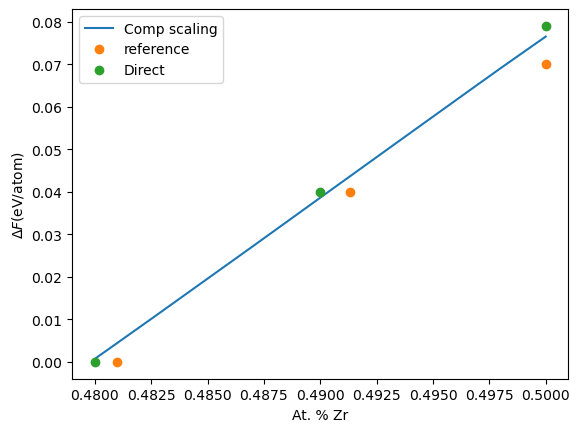

In [12]:
plt.plot(comp, netfe, label="Comp scaling")
plt.plot(comp_reference, fe_reference[0]-fe_reference, "o", label="reference")
plt.plot(comp_direct, fe_direct[0]-fe_direct, "o", label="Direct")
plt.legend()
plt.xlabel("At. % Zr")
plt.ylabel(r"$ \Delta F $(eV/atom)");

As seen from the plot, we have excellent agreement. However, we can obtain the whole range from a single calculation.

<div class="admonition note" name="html-admonition" style="background: #ef5350; padding: 10px">
<p class="title"><b>Free energy due to mixing!</b></p>
The composition integration method does not capture the free energy due to mixing. If the composition range over which the integration is performed is large, the end-points will be correct, however, free energies of the intermediate compositions will not include the mixing contribution!
</div>